# How well do the number of bedrooms/bathrooms and square feet predict the tax-assessed value of single-unit residential properties in three Southern California counties during from May to June 2017?

#### Sean Oslin
#### October 21, 2019

## Project planning phase

### Project goal/research question

To predict the values of single-unit properties that the tax district assesses using the property data from those whose last transaction was during the "hot months" (in terms of real estate demand) of May and June in 2017.

### Deliverables

1. Presentation of the analysis findings usable by management for decision making
2. MySQL notebook with database queries that were imported into Python for analysis
3. Data definitions and analysis notes
4. Data analysis in a Jupyter Notebook that will allow for replication of analysis
5. Github repository holding the analysis and supporting materials

### Minimum viable product

Analysis of how 3 variables (bedroom count, bathroom count and square feet), singlely and in combination predict the tax assessment value for three counties in Southern California as compared to the baseline.

### Null and alternative hypotheses

H<sub>0</sub> : The number of bathrooms, bedrooms and number of square feet in a single-unit residence do not predict the assessed tax value

H<sub>a</sub> : The number of bathrooms, bedrooms and number of square feet in a single-unit residence predict the assessed tax value

## Data acquisition and preparation phases

The sole data source was the Zillow relational database. Data was cleaned and prepared using MySQL and then uploaded to Python for additional preparation and analysis. For detailed information on data preparation please see.........

### Python libraries used for analysis

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.linear_model import LinearRegression
from math import sqrt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

### Python programming for this analysis imported from a text editor

In [ ]:
import env
import wrangle_z
import z_split_scale

### Import of prepared Zillow data from the text editor to this notebook

In [67]:
df_z = wrangle_z.wrangle_zillow()

### Verification that all null values have been removed

In [78]:
df_z.isnull().sum()

Property Description    0
Number of Bathrooms     0
Number of Bedrooms      0
Square Feet             0
Tax Appraised Value     0
Assessed Tax            0
County Number           0
dtype: int64

### Data types adjusted to best suit each variable

In [74]:
df_z['County Number'] = df_z['County Number'].astype('int64')
df_z['Tax Appraised Value'] = df_z['Tax Appraised Value'].astype('int64')
df_z['Square Feet'] = df_z['Square Feet'].astype('int64')
df_z['Number of Bedrooms'] = df_z['Number of Bedrooms'].astype('int64')

### Summary of data types, numbers of rows (individual real estate properties) and data columns

In [77]:
df_z.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15963 entries, 0 to 15962
Data columns (total 7 columns):
Property Description    15963 non-null object
Number of Bathrooms     15963 non-null float64
Number of Bedrooms      15963 non-null int64
Square Feet             15963 non-null int64
Tax Appraised Value     15963 non-null int64
Assessed Tax            15963 non-null float64
County Number           15963 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 997.7+ KB


## Data exploration and pre-processing phases

### Random sample of data

In [76]:
df_z.sample(4)

,Property Description,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number
14672,Single Family Residential,2.0,3,1846,171760,2532.13,6037
8811,Single Family Residential,2.5,3,2723,862000,8670.72,6059
14781,Single Family Residential,1.0,2,1045,156323,2296.84,6037
15360,Single Family Residential,2.0,4,1479,227572,3289.43,6037


### Descriptive statistics

In [79]:
df_z.describe()

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number
count,15963.000000,15963.000000,15963.000000,1.596300e+04,15963.000000,15963.000000
mean,2.215749,3.252835,1837.059199,4.633165e+05,5680.536779,6044.516758
std,1.026447,0.949797,984.656553,6.432976e+05,7465.277971,17.335701
min,1.000000,1.000000,320.000000,1.216800e+04,49.180000,6037.000000
25%,2.000000,3.000000,1233.000000,1.820635e+05,2495.545000,6037.000000
50%,2.000000,3.000000,1592.000000,3.204320e+05,4063.980000,6037.000000
75%,3.000000,4.000000,2162.500000,5.284255e+05,6408.970000,6037.000000
max,20.000000,25.000000,26345.000000,1.912982e+07,228999.210000,6111.000000


### Median values - mean and median values for bathrooms, bedrooms and square footage are close in value, allowing for an assumption of normality

In [117]:
df_z.median()

Number of Bathrooms         2.00
Number of Bedrooms          3.00
Square Feet              1592.00
Tax Appraised Value    320432.00
Assessed Tax             4063.98
County Number            6037.00
dtype: float64

### Visualizations of the data set

#### Distribution of the number of bathrooms by assessed tax - there are significant outliers for assessed taxes for houses with mean number of bathrooms

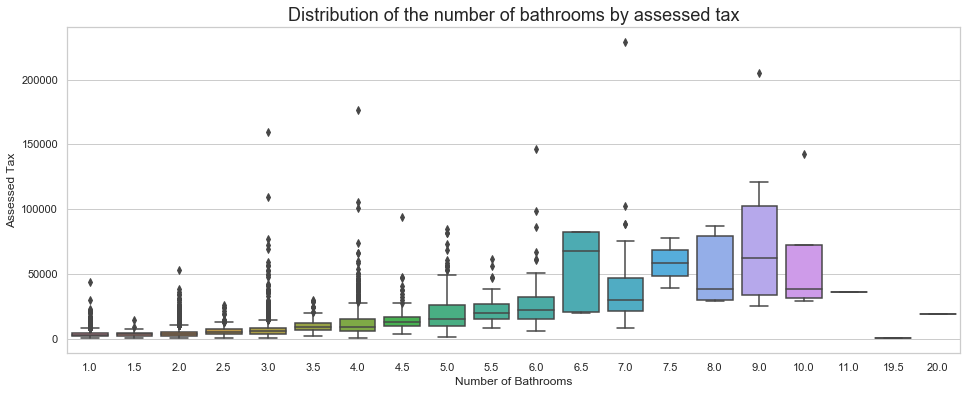

In [150]:
plt.figure(figsize=(16, 6))
ax1 = sns.boxplot(x=df_z["Number of Bathrooms"], y=df_z["Assessed Tax"], data=df_z)\
.set_title('Distribution of the number of bathrooms by assessed tax', fontsize = 18)

#### Distribution of the number of bedrooms by assessed tax - there are significant outliers for assessed taxes for houses with mean number of bedrooms

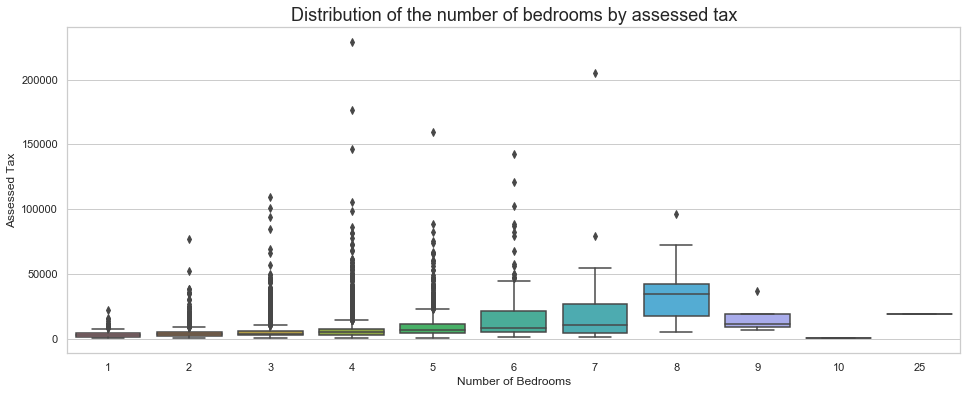

In [151]:
plt.figure(figsize=(16, 6))
ax2 = sns.boxplot(x=df_z["Number of Bedrooms"], y=df_z["Assessed Tax"], data=df_z)\
.set_title('Distribution of the number of bedrooms by assessed tax', fontsize = 18)

#### Histogram of the single-unit square footage - this is a fairly normal distribution with a long tail for mansions

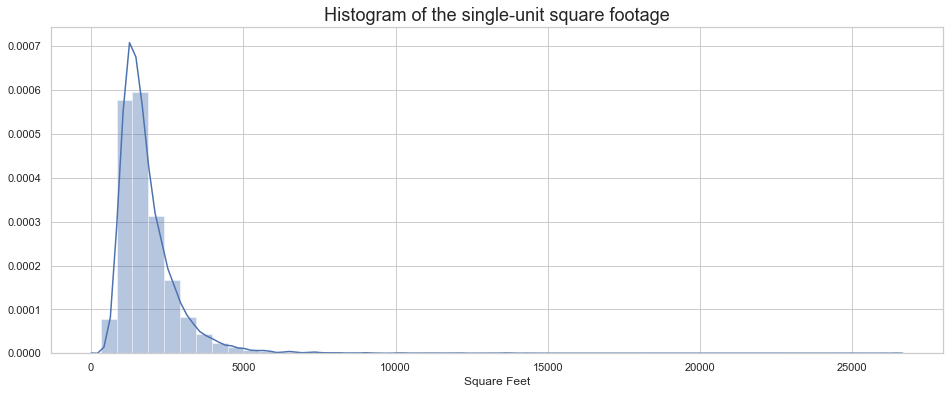

In [152]:
plt.figure(figsize=(16, 6))
ax3 = sns.distplot(df_z['Square Feet'])\
.set_title('Histogram of the single-unit square footage', fontsize = 18)

### Split variables into X and y, then train and test

 #### Remove columns of data not necessary for this phase of the analysis and create a new dataframe for the y variable

In [110]:
X = df_z.drop(columns=['Property Description', 'Tax Appraised Value', 'Assessed Tax', 'County Number'])
y=df_z[['Tax Appraised Value']]

#### Split the modified/new variables into train and test, with 80% of data rows in the two train variables.

In [81]:
x_train, x_test, y_train, y_test = z_split_scale.split_my_data(X,y)

#### Sample of x_train data to verify split and column changes occured

In [154]:
x_train.sample(2)

,Number of Bathrooms,Number of Bedrooms,Square Feet
13901,2.0,5,2430
7367,3.0,5,1871


#### Sample of y_test data to verify new column was created and the split occured

In [155]:
y_train.sample(2)

,Tax Appraised Value
15815,304584
10609,783388


### Visualization of the split x variable

#### Pair plot showing histogram and scatter plot of each combination of x_train variable (i.e. bathrooms, bathrooms and square feet)

Text(0.5, 0.98, 'Histogram and scatter plot for every combinaiton of x_train variable')

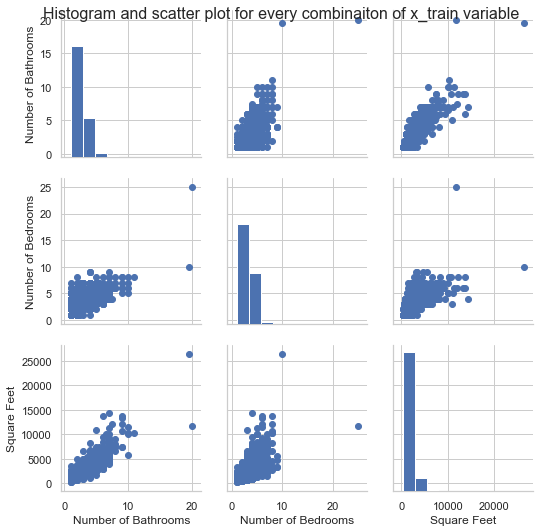

In [166]:
g = sns.PairGrid(x_train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.fig.suptitle('Histogram and scatter plot for every combinaiton of x_train variable', fontsize = 16)

## Apply standard scaler to x_train and x_test

#### Because of assumption that the x (dependent) variables are normally distributed, the standard scaler will be used.

In [18]:
train_x_scaled_data, test_x_scaled_data,scaler_x_train, scaler_x_test = z_split_scale.standard_scaler(x_train,x_test)

#### Verify data scaler has transformed independent variables to harmonize the scales among the variables

In [168]:
train_x_scaled_data.head(2)

,Number of Bathrooms,Number of Bedrooms,Square Feet
8477,0.278822,-0.262844,-0.054008
10275,-0.207660,0.783780,0.016880


# Data modeling

## Run regression on baseline model and regression model

### Baseline (H<sub>0</sub>) model testing whether the average of the number of bedrooms, number of bathrooms and square footage can predict the tax apparised value

In [176]:
y_pred_baseline = np.array([y_train.mean()[0]]*len(y_train))
MSE = mean_squared_error(y_train, y_pred_baseline)
SSE = MSE*len(y_train)
RMSE = sqrt(MSE)

evs = explained_variance_score(y_train, y_pred_baseline)

print('baseline model\n  mean squared error: {:.5}'.format(MSE))
print('  {:.2%} of the variance (r^2) in the tax value can be explained by the baseline (average) model.'.format(evs))

baseline model
  mean squared error: 4.2093e+11
  0.00% of the variance (r^2) in the tax value can be explained by the baseline (average) model.


### With an r^2  of 0, the baseline model provides little to any predictive value for the tax appraised value.

### Regression (H<sub>a</sub>) model testing whether the average of the number of bedrooms, number of bathrooms and square footage can predict the tax apparised value . (Scikit-learn linear regression algorithm was used.)

In [ ]:
lm1 = LinearRegression()

Calculate the y intercept and the coefficients for the 3 dependent variables (number of bathrooms, number of bedrooms and square footage)

In [22]:
lm1.fit(train_x_scaled_data, y_train)
print("Linear Model:", lm1)

lm1_y_intercept = lm1.intercept_
print("intercept: ", lm1_y_intercept)

lm1_coefficients = lm1.coef_
print("coefficients: ", lm1_coefficients)


Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [462043.62960063]
coefficients:  [[  54558.47376137 -137406.19237539  451263.14727761]]


Predicted values for y_train given the linear regression model

In [23]:
y_pred_lm1 = lm1.predict(train_x_scaled_data)
y_pred_lm1

array([[489000.3946324 ],
       [350635.07111573],
       [544289.11543087],
       ...,
       [364555.6651571 ],
       [302651.54268246],
       [663497.55574983]])

In [24]:
mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(y_train, y_pred_lm1)
print('  {:.2%} of the variance in the tax value can be explained by the model.'.format(r2_lm1))

linear model
  mean squared error: 2.4e+11
  42.98% of the variance in the tax value can be explained by the model.


## Distribution of tax rates for each county

In [33]:
df_z['County Tax Rates'] = df_z['Assessed Tax']/df_z['Tax Appraised Value']

In [34]:
df_z.head()

,Property Description,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
0,Single Family Residential,2.0,4.0,1604.0,498347.0,6089.82,6037.0,0.012220
1,Single Family Residential,3.0,3.0,2384.0,549917.0,6679.55,6037.0,0.012146
2,Single Family Residential,2.0,3.0,1574.0,235272.0,3876.31,6037.0,0.016476
3,Single Family Residential,2.0,2.0,1619.0,340000.0,4206.15,6037.0,0.012371
4,Single Family Residential,3.0,2.0,2408.0,2017254.0,24353.42,6037.0,0.012073


In [170]:
v = df_z[df_z['County Number'] == 6111]
l = df_z[df_z['County Number'] == 6037]
o = df_z[df_z['County Number'] == 6059]

KeyError: 'County Tax Rates'

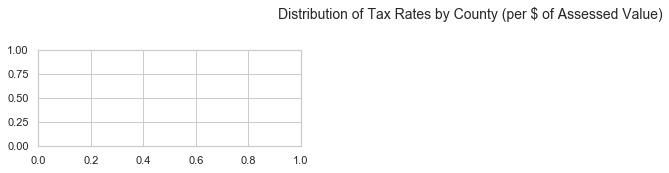

In [171]:

plt.figure(figsize=(16, 6))
plt.suptitle('Distribution of Tax Rates by County (per $ of Assessed Value)', fontsize=14)

plt.subplot(331)
sns.distplot(l['County Tax Rates'])
plt.title('Los Angeles')

plt.subplot(332)
sns.distplot(o['County Tax Rates'])
plt.title('Orange')

plt.subplot(333)
sns.distplot(v['County Tax Rates'])
plt.title('Ventura')
plt.show()

In [61]:
Los_Angeles_County = l.describe()
Los_Angeles_County

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
count,12388.000000,12388.000000,12388.000000,1.238800e+04,12388.000000,12388.0,12388.000000
mean,2.149661,3.177510,1772.191637,4.464855e+05,5611.552369,6037.0,0.013736
std,1.045680,0.956073,950.439448,6.415080e+05,7656.803041,0.0,0.003985
min,1.000000,1.000000,320.000000,1.216800e+04,125.950000,6037.0,0.000303
25%,1.000000,3.000000,1197.000000,1.700000e+05,2416.067500,6037.0,0.012147
50%,2.000000,3.000000,1532.000000,2.982050e+05,3911.960000,6037.0,0.012638
75%,3.000000,4.000000,2059.250000,4.944260e+05,6146.047500,6037.0,0.014012
max,20.000000,25.000000,14342.000000,1.912982e+07,228999.210000,6037.0,0.155072


In [63]:
Orange_County = o.describe()
Orange_County

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
count,2780.000000,2780.000000,2780.000000,2.780000e+03,2780.000000,2780.0,2780.000000
mean,2.462050,3.498201,2075.428058,5.483000e+05,6233.562180,6059.0,0.012111
std,0.947383,0.886708,1109.588740,7.094007e+05,7386.973146,0.0,0.002231
min,1.000000,1.000000,388.000000,1.611900e+04,345.720000,6059.0,0.000032
25%,2.000000,3.000000,1415.000000,2.465898e+05,2908.670000,6059.0,0.010805
50%,2.500000,3.000000,1853.000000,4.091510e+05,4706.300000,6059.0,0.011702
75%,3.000000,4.000000,2467.750000,6.488870e+05,7248.965000,6059.0,0.012622
max,19.500000,10.000000,26345.000000,1.168967e+07,121161.260000,6059.0,0.046414


In [65]:
Ventura_County = v.describe()
Ventura_County

,Number of Bathrooms,Number of Bedrooms,Square Feet,Tax Appraised Value,Assessed Tax,County Number,County Tax Rates
count,795.000000,795.000000,795.000000,7.950000e+02,795.000000,795.0,795.000000
mean,2.384277,3.568553,2014.309434,4.284085e+05,4821.628931,6111.0,0.011491
std,0.819591,0.850999,890.610077,3.268902e+05,3587.999743,0.0,0.001842
min,1.000000,1.000000,572.000000,1.678200e+04,49.180000,6111.0,0.000367
25%,2.000000,3.000000,1444.500000,2.372000e+05,2716.540000,6111.0,0.010695
50%,2.000000,4.000000,1826.000000,3.732460e+05,4299.460000,6111.0,0.011203
75%,3.000000,4.000000,2356.000000,5.423780e+05,6053.900000,6111.0,0.011782
max,7.500000,6.000000,12086.000000,3.631311e+06,38677.720000,6111.0,0.033626
